In [1]:
import csv
import json
import os
import re
import sys

from PIL import Image, ImageFilter
import imageio
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from scipy import ndimage as ndi
from skimage import feature
from scipy.fftpack import rfft, irfft, fftfreq, rfftfreq
from scipy import interpolate

def file_tree(start):
    """Generate file list in directory"""
    file_list = []
    for root, dirs, files in os.walk(start):
        for f in files:
            if f[0] != '.':
                file_list.append(f)
    return file_list


def process_data(data):
    """Process JSON data"""
    attr = data['attributes']

    timestamp = attr['timestamp']
    message = attr['message']
    author = attr['from']
    turbo = attr['tags']['turbo']
    sub = attr['tags']['subscriber']

    try:
        emotes = attr['tags']['emotes']
        emote_count = sum([len(emotes[key]) for key in emotes.keys()])
    except:
        emote_count = 0
    
    row = {
        'timestamp': timestamp,
        'author': author,
        'message': message,
        'turbo': turbo,
        'sub': sub,
        'emote_count': emote_count
    }

    return row


def high_pass_filter(freq, amp, min_freq):
    df = pd.DataFrame(amp, index=freq, columns=['Amplitude'])
    df = df.copy()
    df[df.index < min_freq] = 0
    return df

def low_pass_filter(freq, amp, max_freq):
    df = pd.DataFrame(amp, index=freq, columns=['Amplitude'])
    df = df.copy()
    df[df.index > max_freq] = 0
    return df

def round_to_val(x, val=30):
    return int(np.round(x/val) * val)

def build_time_frame(ts, before=60, after=10):
    return [ts-before, ts+after]

def build_time_window(ts, before=60, after=10):
    return np.arange(ts-before, ts+after)

def fix_overlap(intervals):
    all_vals = [list(np.arange(interval[0], interval[1]+1)) for interval in intervals]
    all_vals = sorted(list(set([v for row in all_vals for v in row])))
    intervals = []
    start = 0
    for i in range(0, len(all_vals)-1):
        if not start:
            start = all_vals[i]
        elif all_vals[i+1] - all_vals[i] > 1:
            intervals.append([start, all_vals[i]])
            start = 0
        elif i + 1 == len(all_vals) - 1:
            intervals.append([start, all_vals[i+1]])
    return intervals

In [46]:
# Get file list
start = '/Users/Rich/Documents/Twitch/chat/v83196893'
file_list = file_tree(start)
df = []

# Aggregate files into dictionary
for file in file_list:
    get_path = os.path.join(start, file)
    with open(get_path) as f:
        # Format line and separate multiple JSON strings with commas
        line = '[{}]'.format(f.readline()).replace('}}{', '}},{')
        data = json.loads(line)[0]

        for message in data['data']:
            df.append(process_data(message))

# Create data frame from chat data and convert ms to s
df = pd.DataFrame(df)
minimum = df['timestamp'].min()
maximum = df['timestamp'].max()
df['timestamp'] = df['timestamp'].apply(lambda x: x - minimum)
df['secondstamp'] = df['timestamp'].apply(lambda x: int(round(x/1000)))
df['30sec_stamp'] = df['timestamp'].apply(lambda x: int(round(x/1000/30)*30))

# Create chat frequency data frame where index is no. of seconds into video
chat_freq = df['30sec_stamp'].value_counts().sort_index()
chat_freq = pd.DataFrame(chat_freq)
chat_freq.columns = ['frequency']

In [53]:
stats = pd.read_csv('./statuses/test.csv')
try:
    stats = stats.drop('Unnamed: 0', 1)
except:
    pass
stats = stats.fillna(0)
stats.rename(columns={'frame': 'second'}, inplace=True)
stats['second'] = stats['second'].apply(lambda x: x/60)
stats['game'] = 0
stats.head()

,second,red,green,game
0,600.0,1,31,0
1,1380.0,158,76,0
2,1440.0,118,93,0
3,4020.0,36,0,0
4,4620.0,204,175,0


In [54]:
# Set filename
filename = '/Users/Rich/Documents/Twitch/video/dota2ti_v83196893_720p30.mp4'

# Get video id
video_id = re.findall('v\d+', filename)[0]

# Open file handle
vid = imageio.get_reader(filename, 'ffmpeg')

# Get metadata
meta = vid.get_meta_data()
fps = int(meta['fps'])
nframes = meta['nframes']
frames = np.arange(0, int(nframes), 1)

# Close video
vid.close()

# Convert frames to seconds and initialize data frame
values = [0] * int(len(frames)/fps)
df = pd.DataFrame(values).reset_index()
df.columns = ['second', 'game']
smear_df = df.copy()

# Import timecode data
timecodes = pd.read_csv('./timecodes/timecodes_v83196893.csv', names=['start', 'stop'])
timecodes = timecodes.astype(int)

# Smear timecodes to remove anything < 30 seconds long
smear_tc = timecodes[timecodes['stop'] - timecodes['start'] >= 30000].reset_index(drop=True)

# Run through smeared timecodes and flip switches on correct seconds of video
for i in smear_tc.index:
    row = smear_tc.iloc[i][['start', 'stop']]
    start = row[0]/fps
    stop = row[1]/fps
    df.loc[(df.index >= start) & (df.index < stop), 'game'] = 1
    stats.loc[(stats['second'] >= start) & (stats['second'] < stop), 'game'] = 1
    stats.loc[(stats['second'] == start) | (stats['second'] == stop), 'game'] = 0

In [55]:
# Adjust stats to center both and get z-score
stats.loc[(stats['game'] != 1, ['red', 'green'])] = 0
stats['red_z'] = (stats['red'] - stats['red'].mean())/stats['red'].std(ddof=0)
stats['green_z'] = (stats['green'] - stats['green'].mean())/stats['green'].std(ddof=0)
stats['red'] = stats['red'].apply(lambda x: (x - stats['red'].mean()))
stats['green'] = stats['green'].apply(lambda x: (x - stats['green'].mean()))

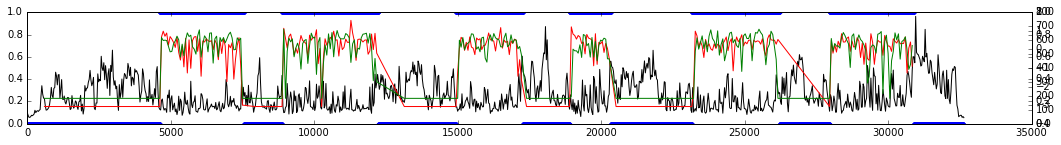

In [56]:
fig, ax1 = plt.subplots(figsize=(18,2))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()
ax1.plot(df.index, df['game'], '.b')
ax2.plot(chat_freq.index, chat_freq['frequency'], '-k')
ax3.plot(stats['second'], stats['red_z'], '-r')
ax3.plot(stats['second'], stats['green_z'], '-g')

In [ ]:
df_copy = df[0:len(chat_freq)]
cf_copy['game'] = df_copy['game']
cf_copy.loc[cf_copy['game'] != 1, 'game'] = 0

fig, ax1 = plt.subplots(figsize=(18,2))
ax2 = ax1.twinx()
ax1.plot(df.index, df['game'], '.b')
ax2.plot(cf_copy.index, cf_copy['frequency'], '-r')

In [ ]:
# Generate CDF
cdf = cf_copy['frequency'].loc[cf_copy['frequency'] > 0].sort_values()
cum_dist = np.linspace(0.,1.,len(cdf))
cdf = pd.Series(cum_dist, index=cdf)
cdf.plot(drawstyle='steps')

In [ ]:
# Generate CDF
cdf = cf_copy['frequency'].loc[cf_copy['frequency'] > 0].sort_values()
cdf = cdf.apply(lambda x: np.log(x))
cum_dist = np.linspace(0.,1.,len(cdf))
cdf = pd.Series(cum_dist, index=cdf)
cdf.plot(drawstyle='steps')

In [ ]:
cf_filt = cf_copy.copy()
freq_max = cf_filt['frequency'].max()
threshold = 0.4
cf_filt.loc[cf_filt['frequency'] < threshold * freq_max, 'frequency'] = 0

fig, ax1 = plt.subplots(figsize=(18,2))
ax2 = ax1.twinx()
ax1.plot(df.index, df['game'], '.b')
ax2.plot(cf_filt.index, cf_filt['frequency'], '-r')

In [ ]:
threshold_times = list(cf_filt.loc[cf_filt['frequency'] > 0].index)

time_frames = fix_overlap([build_time_frame(t, 3, 3) for t in threshold_times])

In [ ]:
df_interesting = df.copy()
df_interesting['game'] = 0
for row in time_frames:
    start, stop = row
    df_interesting.loc[(df.index >= start) & (df.index < stop), 'game'] = 1

In [ ]:
cf_filt = cf_copy.copy()
freq_max = cf_filt['frequency'].max()
threshold = 0.4
cf_filt.loc[cf_filt['frequency'] < threshold * freq_max, 'frequency'] = 0

fig, ax1 = plt.subplots(figsize=(18,2))
ax2 = ax1.twinx()
ax1.plot(df_interesting.index, df_interesting['game'], '.b')
ax2.plot(cf_filt.index, cf_filt['frequency'], '-r')

In [ ]:
time_frames

In [ ]:
threshold_times = list(cf_filt.loc[cf_filt['frequency'] > 0].index)
time_frames = fix_overlap([build_time_frame(t,1,0) for t in threshold_times])

df_uninteresting = df.copy()
df_uninteresting['game'] = 0
for row in time_frames:
    start, stop = row
    df_uninteresting.loc[(df.index >= start) & (df.index < stop), 'game'] = 1

cf_filt = cf_copy.copy()
freq_max = cf_filt['frequency'].max()
threshold = 0.4
cf_filt.loc[cf_filt['frequency'] > threshold * freq_max, 'frequency'] = 0

fig, ax1 = plt.subplots(figsize=(18,2))
ax2 = ax1.twinx()
ax1.plot(df_uninteresting.index, df_uninteresting['game'], '.b')
ax2.plot(cf_filt.index, cf_filt['frequency'], '-r')

In [58]:
df.head()

,second,game
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


NameError: name 'cf' is not defined